# Calculating cyclone density

Import all the necessary libraries

In [1]:
%matplotlib inline
from functools import partial
from pathlib import Path

from octant import RUNTIME
from octant.core import TrackRun
from octant.misc import check_by_mask

RUNTIME.enable_progress_bar = True

Define the common data directory

In [2]:
sample_dir = Path('.') / 'sample_data'

Data are usually organised in hierarchical directory structure. Here, the relevant parameters are defined.

In [3]:
dataset = 'era5'
period = 'test'
run_id = 0

Construct the full path

In [4]:
track_res_dir = sample_dir / dataset / f'run{run_id:03d}' / period

## Load the data

Load land-sea mask array from ERA5 dataset:

In [5]:
import xarray as xr

In [6]:
lsm = xr.open_dataarray(sample_dir / dataset / 'lsm.nc')
lsm = lsm.squeeze()  # remove singular time dimension

Now load the cyclone tracks themselves

In [7]:
tr = TrackRun(track_res_dir)

### Classify the tracks

In [8]:
c = [
    ('aa', [lambda ot: ot.lifetime_h >= 6, partial(check_by_mask, trackrun=tr, lsm=lsm, rad=50.)]),
    ('bb', [lambda ot: (ot.vortex_type != 0).sum() / ot.shape[0] < 0.2,
            lambda ot: ot.gen_lys_dist_km > 300.0]),    
]

In [9]:
tr.classify(c, True)

In [10]:
tr.rename_cats(**{'aa': 'cat1', 'bb': 'cat2'})

In [11]:
tr

<octant.core.TrackRun> [671 tracks]

## Calculate density

In [12]:
import numpy as np

First, arrays of longitude and latitude are needed to define the grid (1 degree step in this case).

In [13]:
lon_dens1d = np.arange(-20., 50.1, 1)
lat_dens1d = np.arange(65., 85.1, 1)

### Cell-based method

The simplest method to calculate cyclone density is to loop over grid cells and sum up tracks' occurence in each of them. By default, the cell counts are divided by grid cell areas so the units are cyclone (tracks) per $km^{2}$.

In [14]:
dens = tr.density(lon_dens1d, lat_dens1d)

Here it is assumed that both arrays represent grid cell centres. Otherwise, the `density()` method should be called with `grid_centres=False`.

Note that if `subset=` keyword is not given, the computation is done for all existing categories:

In [15]:
dens

{'unknown': <xarray.DataArray 'point_density' (latitude: 21, longitude: 71)>
 array([[0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
        [0.000994, 0.00696 , 0.003182, ..., 0.      , 0.      , 0.      ],
        [0.007659, 0.001656, 0.000414, ..., 0.      , 0.      , 0.      ],
        ...,
        [0.011282, 0.005309, 0.003318, ..., 0.      , 0.001327, 0.003318],
        [0.      , 0.      , 0.      , ..., 0.000774, 0.      , 0.      ],
        [0.      , 0.      , 0.      , ..., 0.000928, 0.      , 0.001856]])
 Coordinates:
   * longitude  (longitude) float64 -20.0 -19.0 -18.0 -17.0 ... 48.0 49.0 50.0
   * latitude   (latitude) float64 65.0 66.0 67.0 68.0 ... 82.0 83.0 84.0 85.0
 Attributes:
     units:    km-2
     subset:   unknown
     method:   cell,
 'cat1': <xarray.DataArray 'point_density' (latitude: 21, longitude: 71)>
 array([[0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , ..., 0.      , 0.     

The output of `TrackRun.density()` is an `xarray.DataArray` with useful metadata and coordinates.

In [16]:
arr = dens['cat1']

In [17]:
arr.attrs

OrderedDict([('units', 'km-2'), ('subset', 'cat1'), ('method', 'cell')])

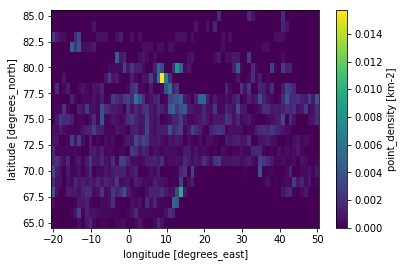

In [18]:
arr.plot();

Of course, these data are not very useful without weighting it by grid cell areas, but it can be retrieved by calling the function again:

In [19]:
dens_nonweighted = tr.density(lon_dens1d, lat_dens1d, weight_by_area=False)

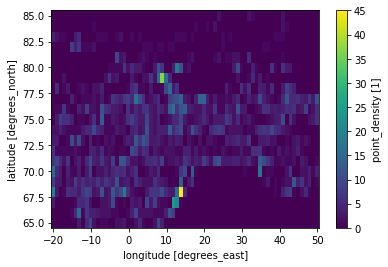

In [20]:
dens_nonweighted['cat1'].plot();

Area weights are calculated by `octant.grid.grid_cell_areas()` function.

### Grid centres vs bounds

Here is what coordinates of the density array look like, e.g. longitude:

In [21]:
arr.longitude

<xarray.DataArray 'longitude' (longitude: 71)>
array([-20., -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,  -9.,
        -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,
         4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,
        16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,
        28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,
        40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.])
Coordinates:
  * longitude  (longitude) float64 -20.0 -19.0 -18.0 -17.0 ... 48.0 49.0 50.0
Attributes:
    units:    degrees_east

Density is calculated assuming these are grid cell **centres**.

It can be also assumed that `lon_dens1d` and `lat_dens1d` are grid cell **boundaries**.

In [22]:
dens_b = tr.density(lon_dens1d, lat_dens1d, grid_centres=False)

Note how the shape and values of longitude (and latitude) change:

In [23]:
dens_b['cat1'].longitude

<xarray.DataArray 'longitude' (longitude: 70)>
array([-19.5, -18.5, -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,
        -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,
         0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,   9.5,
        10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,  18.5,  19.5,
        20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,  27.5,  28.5,  29.5,
        30.5,  31.5,  32.5,  33.5,  34.5,  35.5,  36.5,  37.5,  38.5,  39.5,
        40.5,  41.5,  42.5,  43.5,  44.5,  45.5,  46.5,  47.5,  48.5,  49.5])
Coordinates:
  * longitude  (longitude) float64 -19.5 -18.5 -17.5 -16.5 ... 47.5 48.5 49.5
Attributes:
    units:    degrees_east